In [2]:
import numpy as np
import os
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

In [3]:
def get_eval_metric(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'acc\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            word = re.findall(target_str, line)[0]
            mtc = re.findall(number_str, word)[0]
            
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def insert_10(left, right):
    l = [left + 1]
    for i in range(left, right):
        if (i - left -1) % 10 == 0 and i != left + 1:
            l.append(i)
    l.append(right)
    return l

def merge_stack(lists):
    for i in range(len(lists)):
        merged_l = []
        l = lists[i]
        for a in l:
            for b in a:
                merged_l.append(b)
        lists[i] = merged_l
    return lists

def cut(x,y,upper_bound_acc):
    x = np.array(x) / 3600 # convert second to hour
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y
            
def sum_duration(depth, width, idx, tmp, time, type = "Dyna-A-Freeze", slow_down = 1):
    batch_num = 30
    bw = 1
    latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7]) * slow_down / 4 
    latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08]) * slow_down / 4
    comm_bert = np.array([0.6, 7.7, 14.8, 21.9, 29.0, 36.0, 43.1, 50.2, 57.3, 64.4, 71.5, 78.6, 109.5]) * 4 / bw# 这里面没有仅仅freeze embedding的数据
    adapter_para = 0.0125 * width / 8
    comm_adapter =np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4 / bw
    
    if type == "BERT" or type == "Freeze":
        latency = latency_tx2_baseline
        comm = comm_bert * 2
    if type == "Q-Freeze": # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 8  # INT4 量化
    if type == "Quantize" : # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 4  # INT8 量化
    if type == "A-Freeze" or type == "Dyna-A-Freeze":
        latency = latency_tx2_cached 
        comm = comm_adapter * 2

    comm_tmp = comm[depth]
    duration = 0
    for i in range(0, idx - tmp):
        comp_tmp = latency[depth] * batch_num
        duration = duration + comp_tmp + comm_tmp
        # print(comp_tmp,comm_tmp)
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time


In [4]:
color = ['red', 'blue', 'green', '#FF8C00', '#9370DB', 'hotpink']
marker = ["o", "v", "s", "^", "D", "o"]

[0, 1, 2, 3]
[[40.09633333333333, 73.075, 128.00680555555556, 47.016666666666666], [10.170222222222204, 17.227111111111068, 9.812444444444422, 30], [4.074611111111116, 9.480444444444416, 8.151111111111092, 25], [1.4121111111111115, 4.085444444444456, 7.451111111111095, 20]]


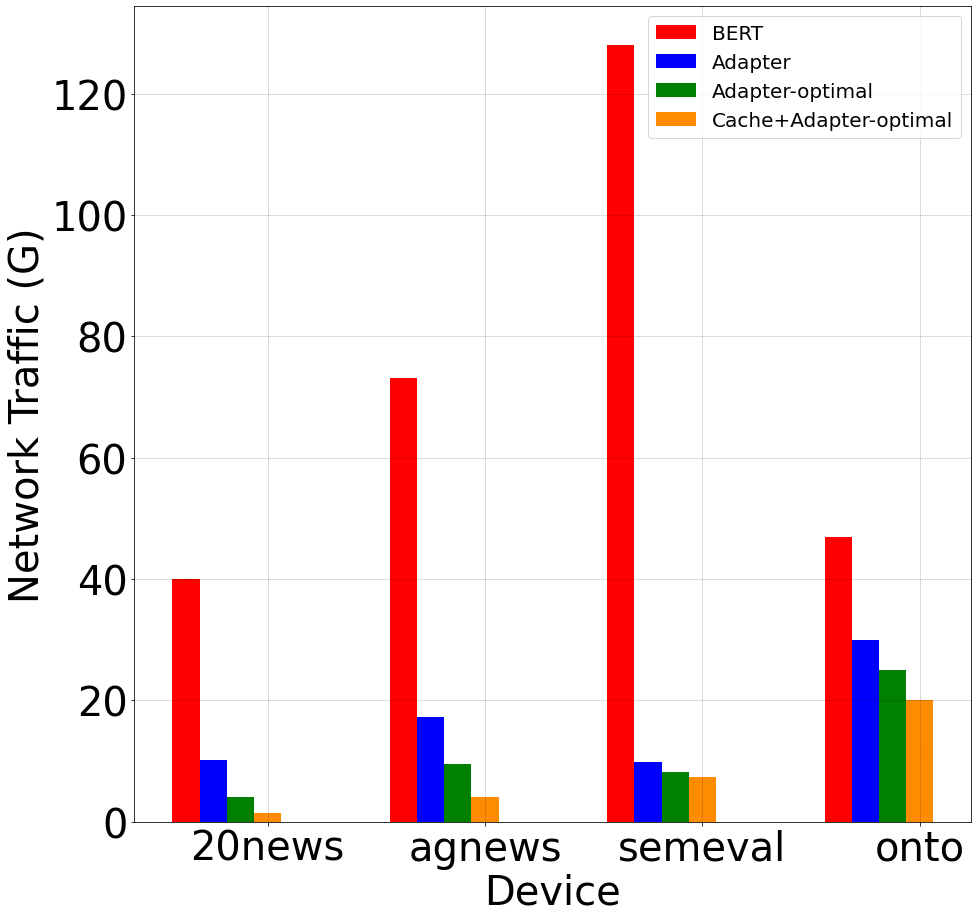

In [10]:
plt.figure(figsize=(15,15))
# 设置刻度字体大小
plt.title("",fontsize=25)
# 设置刻度字体大小
ft = 40
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Device", fontsize=ft)
plt.ylabel("Network Traffic (G)", fontsize=ft)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5, alpha=0.4)

# 这里的onto应该是模拟的到达0.8准确率的时间
runtime = [[40.09633333333333, 73.075, 128.00680555555556, 47.016666666666666], 
[10.170222222222204, 17.227111111111068, 9.812444444444422, 30], # adapter
[4.074611111111116, 9.480444444444416, 8.151111111111092, 25], # adapter optimal
[1.4121111111111115, 4.085444444444456, 7.451111111111095, 20]]
type = ["BERT", "Adapter", "Adapter-optimal", "Cache+Adapter-optimal"]
x = list(range(4))
print(x)
print(runtime)
total_width, n = 1, 8
width = total_width / n
plt.bar(x, runtime[0], width=width, label=type[0], fc=color[0])

for i in range(1,4):
    for j in range(len(x)):
        x[j] = x[j] + width
    plt.bar(x, runtime[i], width=width, label=type[i], fc=color[i])
plt.xticks(x, labels = ["20news", "agnews", "semeval", "onto"])

plt.legend(fontsize=20,ncol = 1)
plt.savefig('../figs/eval-ablation-adapter-cache.pdf', bbox_inches="tight")